In [1]:
import os, torch, pickle 
from model import GPT, GPTConfig
from magicab import ETokenizer 

device = "mps" if not torch.cuda.is_available() else "cuda"
out_dir = "checkpoint/base"
# out_dir = "out-enwiki-char"
ckpt_path = os.path.join(out_dir, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=device)

# Load model 
model = GPT.load_model(checkpoint, device)
model = model.to(device)
model.eval()

# Load tokenizer 
meta_path = os.path.join('data', checkpoint['config']['dataset'], 'meta.pkl')
with open(meta_path, 'rb') as f:
    meta = pickle.load(f)
tok = ETokenizer(char_vocab=meta['itos'])

/var/folders/nn/nbsb8w3570zfgs23h2s0cdzm0000gn/T/ipykernel_19458/1980074258.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_locati

number of parameters: 10.66M


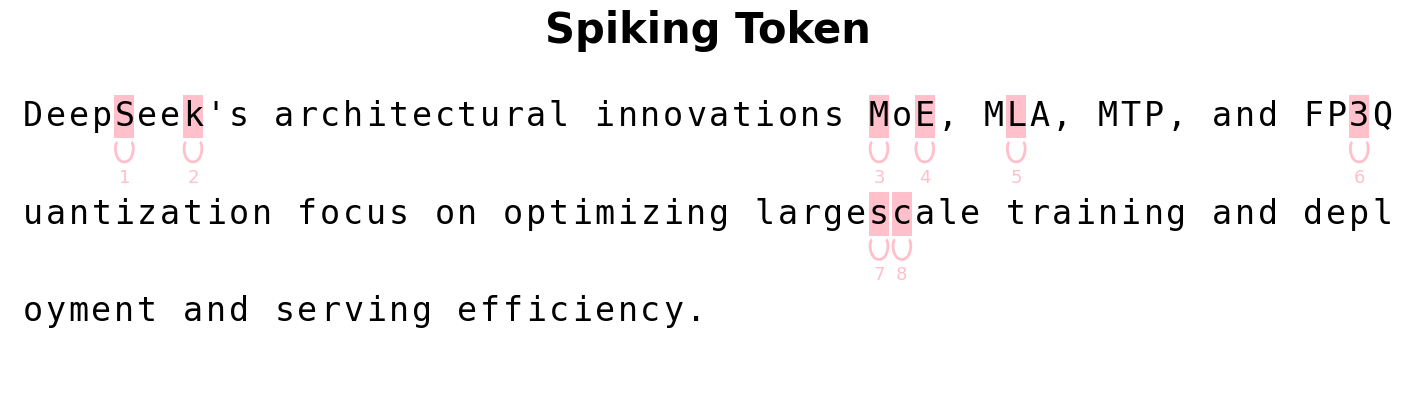

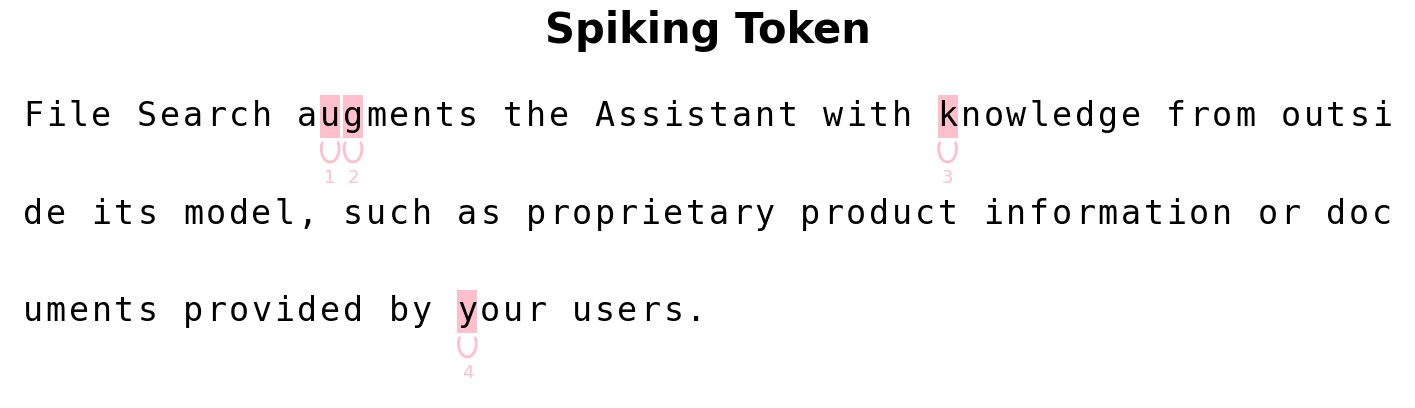

   :: Remove token mask calculation: 0.0004 seconds
   :: Remove token list appending loop: 0.0002 seconds
   :: Remove token group appending loop: 0.0000 seconds


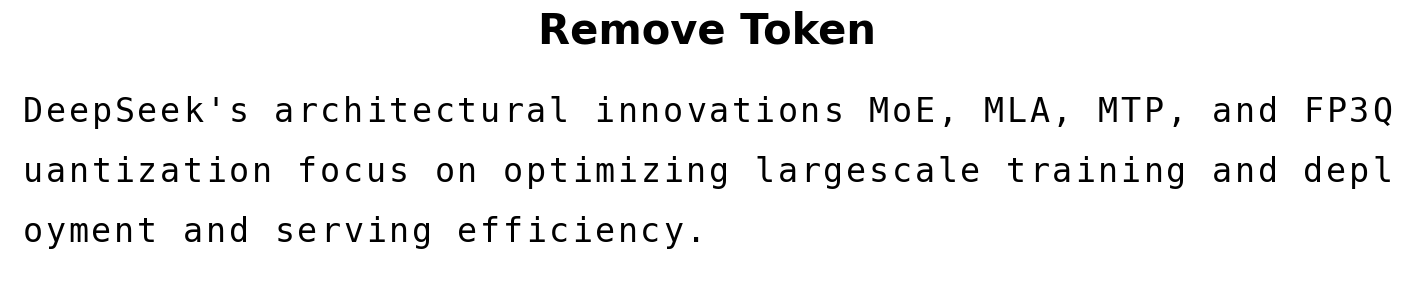

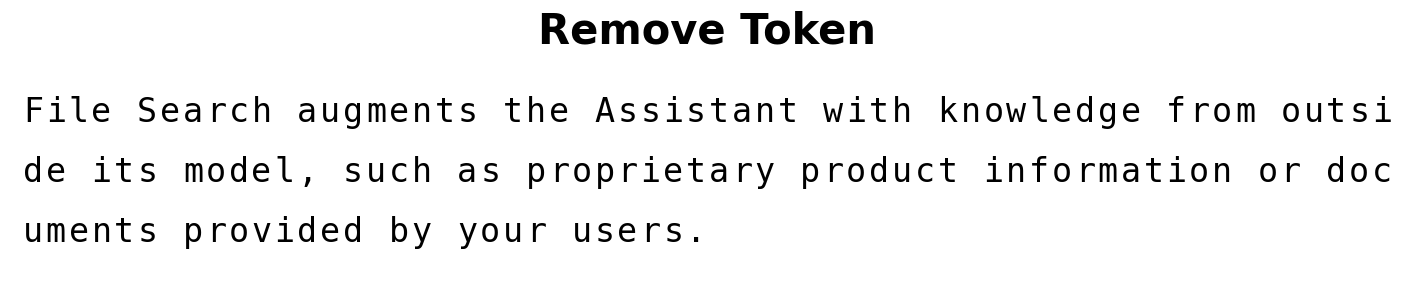

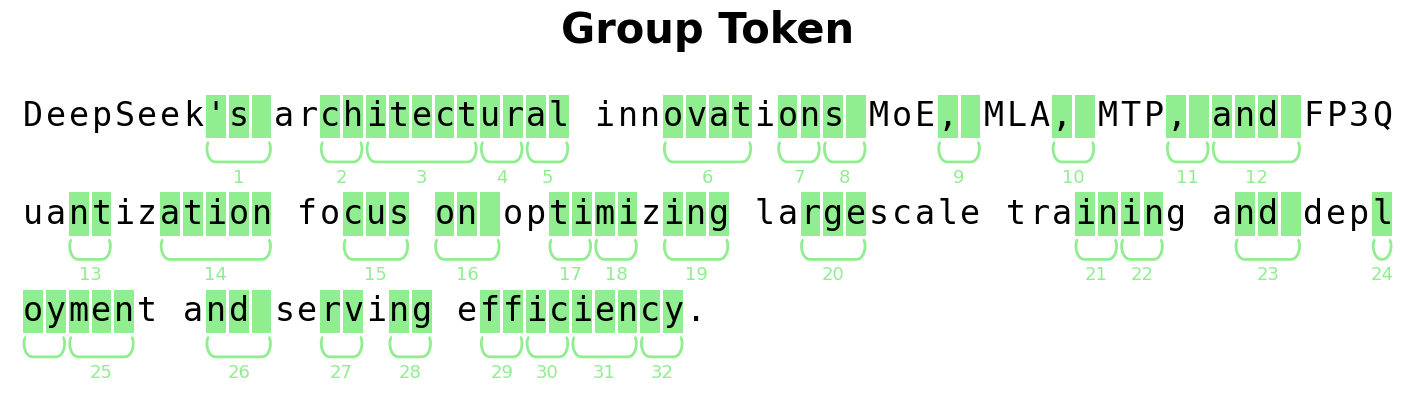

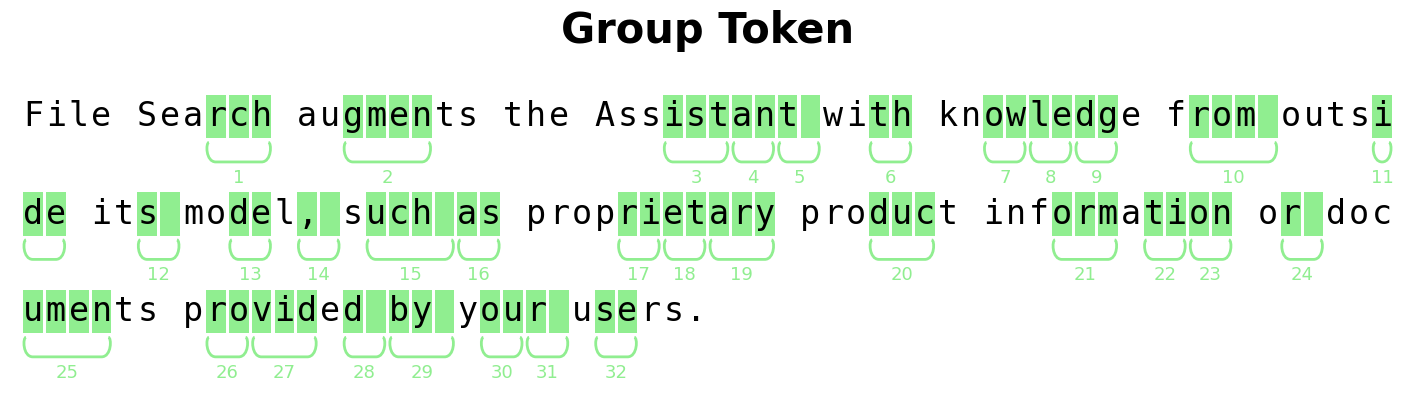

In [2]:
from magicab import Magicab
magicab = Magicab(model, tok, checkpoint_dir="checkpoint/base", spike_perplexity_threshold=5.0, group_perplexity_threshold=0.2)

txt1 = "DeepSeek's architectural innovations MoE, MLA, MTP, and FP3Quantization focus on optimizing largescale training and deployment and serving efficiency."
txt2 = "File Search augments the Assistant with knowledge from outside its model, such as proprietary product information or documents provided by your users."
texts = [txt1, txt2]

# (a). Batch Visualizer
magicab.visualize_changes(texts) # issue: likely empty remove token groups leading to issue in map_to_char functional

In [3]:
from data.enwiki.util import prepare_enwiki_data
from magicab import update_magicab
from magicab.magicab import get_batch
import time 

# Update data with tokenizer (11min --> 40s with rust tokenization)
# t0 = time.time()
# prepare_enwiki_data(clean=True, tokenizer=magicab.tokenizer) # in-place update on trianing data 
# t1 = time.time()
# print("Time taken to update data: ", t1 - t0)

In [4]:
data_dir = "data/enwiki/"
block_size = 256
batch_size = 256
device_type = "mps" if not torch.cuda.is_available() else "cuda"
max_size_change = 2000

update_magicab(magicab, data_dir, block_size, batch_size, device_type, max_size_change)

Updating Magicab Vocabulary:   0%|          | 0/763 [00:00<?, ?it/s]

 - Inference took: 1.2134 seconds
   :: Remove token mask calculation: 0.1309 seconds
   :: Remove token list appending loop: 0.0543 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1853 seconds


Updating Magicab Vocabulary:   0%|          | 1/763 [00:02<25:27,  2.00s/it]

 - Group token detection took: 0.4470 seconds
   :: add_tokens: 0.0129 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.1116 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0022 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0224 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1504 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 1.9979 seconds
 - Inference took: 0.9616 seconds
   :: Remove token mask calculation: 0.0772 seconds
   :: Remove token list appending loop: 0.0525 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1298 seconds
 - Group token detection took: 0.4388 seconds


Updating Magicab Vocabulary:   0%|          | 2/763 [00:03<23:34,  1.86s/it]

   :: add_tokens: 0.0111 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.1118 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0788 seconds
   :: update_caches: per input row  0.0003 seconds
 - Vocabulary addition prep took: 0.2048 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0165 seconds
Function _cache_vocabulary_change took 1.7528 seconds
 - Inference took: 0.9427 seconds
   :: Remove token mask calculation: 0.0588 seconds
   :: Remove token list appending loop: 0.0541 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1130 seconds


Updating Magicab Vocabulary:   0%|          | 3/763 [00:05<22:29,  1.78s/it]

 - Group token detection took: 0.4519 seconds
   :: add_tokens: 0.0125 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.1167 seconds
   :: slice_embeddings: per input row  0.0005 seconds
   :: update_token_addition: 0.0023 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0230 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1558 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0098 seconds
Function _cache_vocabulary_change took 1.6746 seconds
 - Inference took: 0.9481 seconds
   :: Remove token mask calculation: 0.0606 seconds
   :: Remove token list appending loop: 0.0526 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1132 seconds


Updating Magicab Vocabulary:   1%|          | 4/763 [00:07<21:57,  1.74s/it]

 - Group token detection took: 0.4508 seconds
   :: add_tokens: 0.0117 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.1081 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0020 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0224 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1455 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0106 seconds
Function _cache_vocabulary_change took 1.6695 seconds
 - Inference took: 0.9494 seconds
   :: Remove token mask calculation: 0.0601 seconds
   :: Remove token list appending loop: 0.0524 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1126 seconds


Updating Magicab Vocabulary:   1%|          | 5/763 [00:08<21:47,  1.72s/it]

 - Group token detection took: 0.4913 seconds
   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.1041 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0212 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1391 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0090 seconds
Function _cache_vocabulary_change took 1.7027 seconds
 - Inference took: 0.9503 seconds
   :: Remove token mask calculation: 0.2614 seconds
   :: Remove token list appending loop: 0.0645 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.3261 seconds


Updating Magicab Vocabulary:   1%|          | 5/763 [00:10<26:34,  2.10s/it]


KeyboardInterrupt: 

In [4]:
data_dir = "data/enwiki/"
block_size = 256
batch_size = 256
device_type = "mps" if not torch.cuda.is_available() else "cuda"

x,y = get_batch('train', data_dir, block_size, batch_size, device_type, device)

In [5]:
magicab.cache_vocab_change(input_ids=x, target_ids=y, avoid_duplicate=False, cal_mask_device="mps")

 - Inference took: 1.0606 seconds
   :: Remove token mask calculation: 0.1252 seconds
   :: Remove token list appending loop: 0.0523 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1776 seconds
 - Group token detection took: 0.2949 seconds
   :: add_tokens: 0.0359 seconds
   :: slice_embeddings: 0.1108 seconds
   :: update_token_addition: 0.0041 seconds
   :: update_caches: 0.0186 seconds
 - Vocabulary addition prep took: 0.1705 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0028 seconds
Function _cache_vocabulary_change took 1.7075 seconds
